<a href="https://colab.research.google.com/github/vadim13213/University/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%969_%D0%9F%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D0%B8%CC%86_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%BE%D1%81%D1%82%D1%83%D0%BF%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D1%81%D0%BE%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B8%CC%86_%D0%B8%D0%BD%D1%84%D1%80%D0%B0%D1%81%D1%82%D1%80%D1%83%D0%BA%D1%82%D1%83%D1%80%D1%8B_%D1%81_%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC_OpenStreetMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работу выполнил: студент Захаренко Вадим Олегович

# **Практическая работа №9. Пространственный анализ доступности социальной инфраструктуры с использованием OpenStreetMap**

## **Цель работы**

Овладеть методами пространственного анализа городских территорий на основе открытых геоданных: загрузка данных из OpenStreetMap, конструирование пространственных признаков и их визуализация на тепловых картах административных районов и гексагональной H3‑сетки.

## **Введение**

Доступность социальной инфраструктуры (школы, детские сады, поликлиники, общественный транспорт и т.п.) является базовой характеристикой качества городской среды. Современные методы геоанализа позволяют количественно оценивать уровень такой доступности для разных участков города и визуализировать результаты в удобной для интерпретации форме.

В данной практической работе вы выполните полный цикл пространственного анализа: от выбора территории и постановки исследовательской задачи до расчёта интегрального показателя доступности и построения тепловых карт по районам и гексагональной ячейке.

## **Задание**

Провести пространственное исследование уровня доступности социальной инфраструктуры для жителей выбранной городской территории, используя данные OpenStreetMap, и визуализировать результаты:

- на карте административных районов;
- на гексагональной H3‑сетке.

---

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [11]:
%%capture
!pip install scikit-learn geopandas h3pandas h3~=3.0 leafmap mapclassify matplotlib seaborn streamlit osmnx openrouteservice polyline -q

In [3]:
# Импорт необходимых библиотек
import geopandas as gpd
import pandas as pd
import numpy as np
import h3
import h3pandas
import leafmap
from shapely.geometry import box
from sklearn.preprocessing import MinMaxScaler
import osmnx as ox
import seaborn as sns
import matplotlib.pyplot as plt

## **Порядок выполнения работы**

### **Часть 1. Подготовка данных и постановка задачи**

1. **Выбор территории и фокуса исследования**

   - Выберите город и область интереса (ROI) для анализа:
     - это может быть весь город или его часть (например, центральные районы, спальный район, новая застройка).
   - Определите фокус исследования:
     - например:
       - доступность школ и детских садов;
       - доступность поликлиник и больниц;
       - комплексная доступность нескольких типов объектов (школы + сады + поликлиники + остановки ОТ).
   - Кратко обоснуйте выбор:
     - почему вы выбрали именно эту территорию;
     - почему выбранный фокус социальной инфраструктуры важен и интересен для анализа.

Для анализа был выбран город Ногинск, его центральная часть со сложившейся исторической и советской застройкой.
Фокус исследования направлен на комплексную доступность школ, детских садов, поликлиник и остановок общественного транспорта. Данный фокус важен, так как охватывает ключевые объекты повседневной жизни и позволяет оценить удобство проживания в центре типичного подмосковного города.


In [4]:
CITY_NAME = "Ногинск"

area = ox.geocode_to_gdf(CITY_NAME)
area.explore()

2. **Определение признаков доступности**

   - Сформулируйте **не менее 5 признаков**, которые, по вашему мнению, характеризуют доступность социальной инфраструктуры для жителей. Примеры признаков:
     - количество объектов нужного типа в шаговой доступности;
     - средняя удалённость до ближайшего объекта;
     - наличие альтернативных видов инфраструктуры (например, частные и государственные школы);
     - транспортная доступность (наличие остановок общественного транспорта поблизости);
     - обеспеченность зелёными зонами рядом с социальной инфраструктурой (парки возле школ и т.п.).
   - Для каждого признака определите, **какими тегами OpenStreetMap** его можно описать. Примеры тегов:
     - `amenity=school`, `amenity=kindergarten`, `amenity=clinic`, `amenity=hospital`;
     - `highway=bus_stop`, `railway=subway_entrance`;
     - `leisure=park`, `leisure=pitch`;
     - границы районов: `boundary=administrative`, `admin_level=*`.
   - Составьте **таблицу соответствия**:

     | признак                     | Описание признака                             | OSM‑теги / атрибуты                       |
     |----------------------------|----------------------------------------------|-------------------------------------------|
     | Кол-во школ в шаговой доступности | Школы в радиусе 800 м от ячейки/района | `amenity=school`                          |
     | Наличие детских садов      | Детсады в радиусе 600 м                     | `amenity=kindergarten`                    |
     | Транспортная доступность   | Остановки ОТ в радиусе 400 м                | `highway=bus_stop`, `railway=tram_stop`   |
     | Близость метро             | Минимальное расстояние до метро             | `railway=subway_entrance`                 |
     | Наличие зелёных зон        | Площадь парков в радиусе 800 м              | `leisure=park`                            |


**ВАША ТАБЛИЦА**

     | признак                             | Описание признака                                          | OSM‑теги / атрибуты       |
     |-------------------------------------|------------------------------------------------------------|---------------------------|
     | Количество школ в пешей доступности | Школы в радиусе 800 м от жилых кварталов                   | `amenity=school`          |
     | Наличие детских садов               | Детсады в радиусе 600 м                                    | `amenity=kindergarten`    |
     | Доступность медицинских учреждений  | Поликлиники в радиусе 1000 м от жилых кварталов            | `amenity=clinic`          |
     | Плотность остановок ОТ              | Количество остановок ОТ в радиусе 400 м от жилых кварталов | `railway=subway_entrance` |
     | Наличие зелёных зон                 | Площадь парков в радиусе 800 м                             | `leisure=park`            |





3. **Сбор исходных данных из OpenStreetMap**

   - Настройте необходимые библиотеки (по аналогии с примером):  
     `osmnx`, `geopandas`, `h3`, `h3pandas`, `leafmap`, `shapely`, `pandas`, `numpy` и др.
   - С помощью интерактивной карты (`leafmap.Map` и инструмент рисования) определите **bounding box** или полигон области интереса.
   - Загрузите из OSM с помощью `osmnx.features_from_bbox()` (или аналогичных функций):
     - объекты социальной инфраструктуры, соответствующие вашим признакам;
     - слои, отражающие административные границы районов (или муниципальных округов).

   - Приведите все пространственные слои к единой системе координат (например, `EPSG:3857` для метрических расчётов).



In [5]:
import osmnx as ox
import warnings

# Функция загрузки данных из OSM
def load_osm_data(polygon):
    # Теги для поиска
    tags = {
        'schools': {'amenity': 'school'},
        'kindergartens': {'amenity': 'kindergarten'},
        #'subways': {'railway': 'subway_entrance'},
        'transport_stops': {'highway': 'bus_stop', 'railway': 'tram_stop'},
        'parks': {'leisure': 'park'},
        'neighborhoods': {'boundary': 'administrative', 'admin_level': '8'},
        'clinics': {'amenity': ['clinic', 'hospital']},
        'buildings': {'building': True},
    }

    # Загрузка данных с обработкой исключений
    data = {}
    for key, tag in tags.items():
        print(f"Загрузка {key}...")
        try:
            gdf = ox.features_from_polygon(polygon, tags=tag)
            data[key] = gdf
        except:
            print(f"Нет данных для {key} в заданном регионе. Создаём пустой GeoDataFrame.")
            # Создаём пустой GeoDataFrame с колонкой 'geometry' и устанавливаем CRS
            data[key] = gpd.GeoDataFrame(columns=['geometry'], crs="EPSG:4326")

    return data

# Загружаем данные
data = load_osm_data(area.geometry.unary_union)

# Приводим данные к нужному CRS
crs_proj = "EPSG:3857"
for key in data.keys():
    # Проверяем, что GeoDataFrame не пустой
    if not data[key].empty and 'geometry' in data[key].columns:
        data[key] = data[key].to_crs(crs_proj)
    else:
        # Если пустой, создаём пустой GeoDataFrame с нужным CRS и колонкой 'geometry'
        data[key] = gpd.GeoDataFrame(columns=['geometry'], crs=crs_proj)
data

Загрузка schools...
Загрузка kindergartens...
Загрузка transport_stops...
Загрузка parks...
Загрузка neighborhoods...
Загрузка clinics...
Загрузка buildings...


{'schools':                                                               geometry  \
 element  id                                                              
 node     934868530                      POINT (4279473.92 7535214.193)   
          2419382215                    POINT (4274355.583 7525843.825)   
          2660182052                    POINT (4278307.169 7534116.083)   
 relation 2783608     POLYGON ((4280633.167 7534348.782, 4280731.518...   
          3576294     POLYGON ((4280176.245 7531143.324, 4280215.653...   
          6273475     POLYGON ((4279796.401 7531598.016, 4279835.163...   
          17843039    POLYGON ((4275956.524 7526871.387, 4275928.36 ...   
 way      107013551   POLYGON ((4275317.784 7526298.562, 4275180.015...   
          107041656   POLYGON ((4274714.165 7526256.891, 4274803.7 7...   
          108876602   POLYGON ((4279462.654 7526586.635, 4279577.302...   
          110413686   POLYGON ((4278355.014 7528923.451, 4278479.18 ...   
          1176

In [12]:
if not data['neighborhoods'].empty:
    neighborhoods = data['neighborhoods'][data['neighborhoods']['admin_level'] == '8'].copy()

    neighborhoods = neighborhoods[
        neighborhoods.geometry.geom_type.isin(["Polygon", "MultiPolygon"])
    ].copy()

    area_union = area.geometry.to_crs("EPSG:3857").unary_union

    neighborhoods = neighborhoods[
        neighborhoods.geometry.within(area_union)
    ].copy()

    if not neighborhoods.empty:
        use_neighborhoods = True
    else:
        use_neighborhoods = False
        print("Нет данных по районам (admin_level=8) для отображения")
else:
    use_neighborhoods = False
    print("В данных отсутствуют районы (neighborhoods)")

center_lat = area.geometry.centroid.y.mean()
center_lon = area.geometry.centroid.x.mean()

m2 = leafmap.Map(center=[center_lat, center_lon], zoom=12)

if use_neighborhoods:
    m2.add_gdf(neighborhoods, layer_name="Районы", style={'color': 'blue', 'fillOpacity': 0.1, 'weight': 2})

if not data["schools"].empty:
    m2.add_gdf(data["schools"],
               point_style={
                   "radius": 7,
                   "color": "red",
                   "fillOpacity": 0.8,
                   "fillColor": "blue",
                   "weight": 2,
               },
               layer_name="Школы")
else:
    print("Нет данных по школам")

if not data["kindergartens"].empty:
    m2.add_gdf(data["kindergartens"],
               point_style={
                   "radius": 6,
                   "color": "red",
                   "fillOpacity": 0.8,
                   "fillColor": "green",
                   "weight": 2,
               },
               layer_name="Детские сады")
else:
    print("Нет данных по детским садам")

if not data["transport_stops"].empty:
    m2.add_gdf(data["transport_stops"],
               point_style={
                   "radius": 4,
                   "color": "black",
                   "fillOpacity": 0.8,
                   "fillColor": "white",
                   "weight": 2,
               },
               layer_name="Остановки транспорта")
else:
    print("Нет данных по остановкам транспорта")

if not data["parks"].empty:
    m2.add_gdf(data["parks"],
               style={'color': 'darkgreen', 'fillOpacity': 0.5, 'weight': 1},
               layer_name="Парки")
else:
    print("Нет данных по паркам")

if 'clinics' in data and not data['clinics'].empty:
    m2.add_gdf(data["clinics"],
               point_style={
                   "radius": 7,
                   "color": "red",
                   "fillOpacity": 0.8,
                   "fillColor": "purple",
                   "weight": 2,
               },
               layer_name="Поликлиники")

m2.add_gdf(area.to_crs("EPSG:4326"),
           layer_name="Граница Ногинска",
           style={'color': 'red', 'fillOpacity': 0, 'weight': 3})

m2.add_layer_control()
m2

Нет данных по районам (admin_level=8) для отображения


Map(center=[np.float64(55.86559834320048), np.float64(38.46043891763474)], controls=(ZoomControl(options=['pos…

---

### **Часть 2. Пространственное агрегирование и инженерия признаков**

1. **Построение гексагональной H3‑сетki**

   - Определите подходящее **разрешение (resolution)** H3‑сетки для вашей территории:
     - маленькое значение (5–7) — крупные ячейки для больших территорий;
     - большое значение (8–10 и выше) — более детальный анализ на уровне кварталов/микрорайонов.
   - Обоснуйте ваш выбор resolution с точки зрения:
     - размера города или ROI;
     - характера объектов (шаговая доступность, плотность застройки);
     - удобства визуализации и интерпретации.
   - Сгенерируйте H3‑индексы, покрывающие выбранный полигон (через `h3.polyfill_geojson`), и создайте `GeoDataFrame` с геометриями ячеек.

Количество гексагонов: 394
          h3_index                                           geometry
0  89118cc6d03ffff  POLYGON ((4285245.212 7531191.477, 4285511.356...
1  89118c893a7ffff  POLYGON ((4281472.647 7533814.46, 4281738.903 ...
2  89118cc6e17ffff  POLYGON ((4284064.472 7524190.461, 4284330.397...
3  89118cc6e33ffff  POLYGON ((4284999.404 7524632.962, 4285265.337...
4  89118c89cbbffff  POLYGON ((4281715.835 7540379.259, 4281982.303...


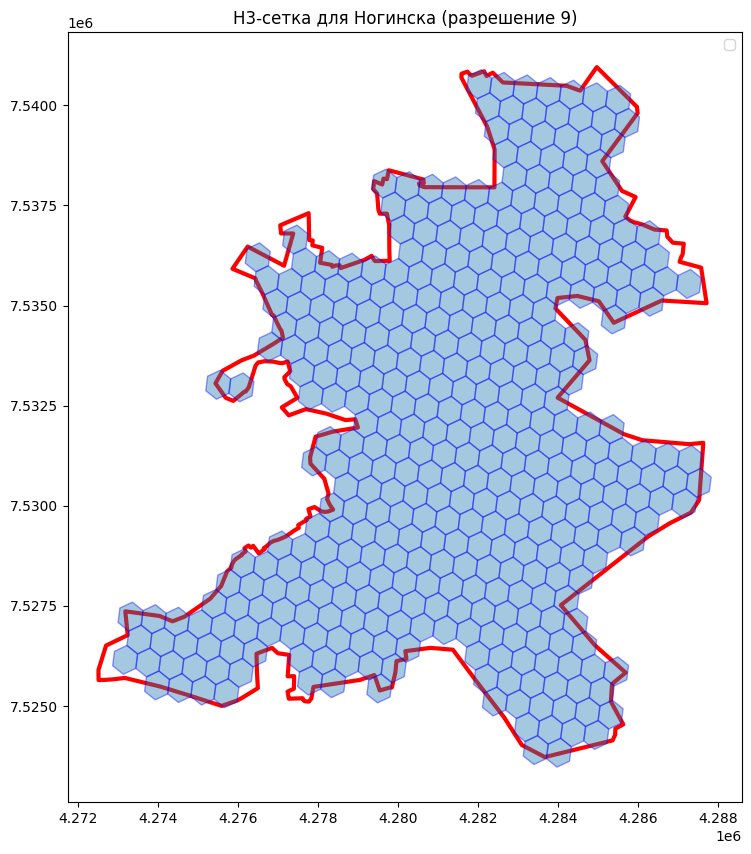

Map(center=[np.float64(55.86559834320048), np.float64(38.46043891763474)], controls=(ZoomControl(options=['pos…

In [15]:
from shapely.geometry import Polygon

H3_RESOLUTION = 9

def h3_to_polygon(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

geom = area.geometry.iloc[0]
resolution = H3_RESOLUTION

hexes = set()

if geom.geom_type == "Polygon":
    hexes |= h3.polyfill_geojson(geom.__geo_interface__, resolution)
elif geom.geom_type == "MultiPolygon":
    for poly in geom.geoms:
        hexes |= h3.polyfill_geojson(poly.__geo_interface__, resolution)

gdf_hexes = gpd.GeoDataFrame(
    {"h3_index": list(hexes)},
    geometry=[h3_to_polygon(h) for h in hexes],
    crs="EPSG:4326"
)

gdf_hexes = gdf_hexes.to_crs("EPSG:3857")

print(f"Количество гексагонов: {len(gdf_hexes)}")
print(gdf_hexes.head())

fig, ax = plt.subplots(figsize=(10, 10))
area.to_crs("EPSG:3857").plot(ax=ax, facecolor="none", edgecolor="red", linewidth=3, label="Граница Ногинска")
gdf_hexes.plot(ax=ax, alpha=0.4, edgecolor="blue", label=f"H3 сетка (разрешение {resolution})")
ax.set_title(f"H3-сетка для Ногинска (разрешение {resolution})")
ax.legend()
plt.show()

m_hex = leafmap.Map(center=[center_lat, center_lon], zoom=12)
m_hex.add_gdf(gdf_hexes.to_crs("EPSG:4326"),
              layer_name=f"H3 сетка (разрешение {resolution})",
              style={'color': 'blue', 'fillOpacity': 0.1, 'weight': 1})
m_hex.add_gdf(area,
              layer_name="Граница города",
              style={'color': 'red', 'fillOpacity': 0, 'weight': 3})
m_hex.add_layer_control()
m_hex

Такой уровень детализации позволяет проводить точный анализ доступности инфраструктуры на уровне отдельных городских кварталов и микрорайонов, что особенно важно для оценки условий проживания в различных частях города.

2. **Агрегирование по административным районам**

   - Подготовьте слой районов (например, `admin_level=8`):
     - при необходимости отфильтруйте только нужный уровень административного деления.
   - Для каждого района рассчитайте показатели, связанные с выбранными типами инфраструктуры. Примеры:
     - количество школ/детсадов/поликлиник внутри района;
     - плотность объектов (количество на км²);
     - суммарная площадь парков;
     - количество остановок ОТ.
   - Добавьте эти признаки в таблицу районов.

In [ ]:
# Ваш код

3. **Инженерия пространственных признаков для H3‑ячеек**

   - Определите радиусы (в метрах) для анализа **окружения ячейки**:
     - например: ближний радиус 400–600 м, средний радиус 800–1200 м.
   - Для каждой H3‑ячейки рассчитайте **не менее 10 пространственных признаков**, например:
     - количество школ в ближнем радиусе;
     - количество детсадов в ближнем и среднем радиусе;
     - количество поликлиник/больниц в среднем радиусе;
     - суммарная площадь парков в ближнем радиусе;
     - количество остановок общественного транспорта в ближнем радиусе;
     - расстояние до ближайшей школы;
     - расстояние до ближайшей поликлиники;
     - расстояние до ближайшей станции метро или ж/д;
     - плотность объектов социальной инфраструктуры (общее число объектов на площадь буфера);
     - отношение количества социальных объектов к количеству зданий (как прокси обеспеченности).
   - **Дополнительное задание**: придумайте и реализуйте **не менее 2 новых признаков**, которых не было в теоретическом материале и примере, например:
     - индекс смешанности инфраструктуры (сколько разных типов объектов есть в радиусе);
     - доля зелёных зон в буфере относительно общей площади буфера;
     - средневзвешенное расстояние до всех школ/садов (а не только ближайшего).

In [ ]:
# Ваш код







4. **Базовый анализ признаков**

   - Рассчитайте простые статистики для признаков районов и H3‑ячеек:
     - минимум, максимум, среднее, медиана, квартилли, стандартное отклонение.
   - Исследуйте взаимные **корреляции** между признаками:
     - выделите группы сильно коррелированных признаков;
     - сделайте промежуточные выводы (например, «в районах с большим числом школ больше и остановок ОТ»).
   - Обнаружьте и обработайте:
     - **пропущенные значения** (NaN);
     - **выбросы** (аномально большие или малые значения признаков).
   - Оформите принятые решения (удаление, заполнение, логарифмирование и т.п.).



In [ ]:
# Ваш код

---

### **Часть 3. Оценка уровня доступности и типология территорий**

1. **Разработка интегрального индекса доступности**

   - Выберите подмножество наиболее важных признаков (по вашему мнению) для оценки доступности:
     - отдельно для районов;
     - отдельно для H3‑ячеек.
   - Нормализуйте выбранные признаки (например, с помощью MinMaxScaler или z‑нормализации), чтобы привести их к сопоставимому масштабу.
   - Определите **веса** для каждого признака:
     - обоснуйте, почему некоторые признакы важнее других;
     - приведите словесное объяснение (например, «наличие школы в шаговой доступности важнее, чем наличие большого парка, поэтому вес признака выше»).
   - Рассчитайте интегральный **индекс доступности** для:
     - каждого административного района;
     - каждой H3‑ячейки.
   - При желании разделите индекс на составляющие:
     - индекс образовательной доступности;
     - индекс медицинской доступности;
     - индекс транспортной доступности;
     - интегральный комбинированный индекс.

In [ ]:
# Ваш код

### **Часть 4. Визуализация результатов и формирование выводов**

1. **Тепловая карта по административным районам**

   - Переведите слой районов обратно в систему координат `EPSG:4326` для отображения.
   - С помощью `leafmap` или `folium` постройте **хороплет‑карту (choropleth)**:
     - заливка районов по значению интегрального индекса доступности;
     - выберите подходящую цветовую схему (например, `Blues`, `Greens`, `YlGnBu`);
     - добавьте легенду с подписью (например, «Индекс доступности социальной инфраструктуры»).
   - При необходимости создайте несколько слоёв:
     - отдельные карты для разных компонент индекса (образование/медицина/транспорт).

In [ ]:
# Ваш код

2. **Тепловая карта по H3‑сетки**

   - Переведите H3‑ячейки в CRS `EPSG:4326`.
   - Постройте отдельную карту, где:
     - каждая H3‑ячейка окрашена в соответствии с индексом доступности или номером кластера;
     - используйте хорошую цветовую палитру (например, `OrRd`, `RdYlGn`);
     - настройте прозрачность заливки, чтобы можно было видеть подложку карты.
   - Добавьте всплывающие подсказки (popup/tooltip) с основными показателями для выбранной ячейки:
     - значение индекса;
     - количество объектов;
     - расстояние до ближайшего объекта и т.п.

In [ ]:
# Ваш код

3. **Выделение зон с высокой и низкой доступностью**

   - Определите **пороги** (например, по квартилям или по значениям индекса), чтобы выделить:
     - зоны с высокой доступностью;
     - зоны с низкой доступностью.
   - На карте H3‑ячеек:
     - визуально выделите несколько локальных «кластеров» высокой и низкой доступности;
     - подпишите или сохраните их идентификаторы (H3‑индекс, координаты).

In [ ]:
# Ваш код







4. **Интерпретация результатов и рекомендации**

   - Подготовьте **краткий текстовый анализ**, в котором:
     - опишите общую картину по району/городу:
       - какие части города наиболее обеспечены социальной инфраструктурой;
       - какие — недообеспечены;
     - проанализируйте различия между:
       - оценкой по районам;
       - и оценкой по H3‑ячеек (более детальный уровень).
   - Сформулируйте **5–7 практических рекомендаций**, например:
     - где целесообразно планировать строительство новых школ/детсадов/поликлиник;
     - какие районы требуют улучшения транспортной доступности;
     - какие зоны уже хорошо обеспечены и могут служить «бенчмарками» для планирования других территорий.
   - Укажите **проблемы исследования**:
     - неполнота данных OSM;
     - отсутствие данных о численности населения;
     - грубые допущения при выборе радиусов и весов.

---

In [ ]:
# Ваш код